# Comparing statistics of NO2 pollution for European cities

In [3]:
from pathlib import Path
import getpass

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio import features

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubStatisticalDownloadClient,
    SentinelHubStatistical,
    SentinelHubRequest,
    bbox_to_dimensions,
    SentinelHubStatistical,
    Geometry,
    parse_time,
)


# Measuring NO2 concentrations

Nitrogen dioxide is primarily produced by the burning of fossil fuels. High concentration of Nitrogen dioxide are widely known to cause inlammation of the airways, with long-term exposure leading to respiratory problems such as asthma and bronchitis. Areas with high-density road networks close to large populations are most at risk of over-exposure. For thise with pre-existing conditions, along with children and the elderly, this risk is more pronounced. Therefore, regular monitoring of Nitrogen dioxide concentrations is essential for avoiding health risks and keepint track of pollution.
The main objective of the Copernicus Sentinel-5P mission is to perform atmospheric measurements with high spatio-temporal resolution, to be used for air quality, ozone & UV radiation, and climate monitoring & forecasting.

Sources: https://www.aeroqual.com/measurements/nitrogen-dioxide, 
https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p

The Copernicus Browser and the connected APIs offer you new and more efficient ways to access and analyse data. 

## Outline

This notebook analyses air pollution in Europe using the TROPOMI sensor on the Sentinel 5P satellite. This notebook aims to provide data to answer the following questions:

- What is the spatial distribution of NO2 concentration in Europe
- How does the NO2 concentration vary over a year
- Which European capitals are most affected by NO2 emissions

## Used tools and features

To carry out these analyses we will cover a few different concepts and features available on the Copernicus Dataspace Ecosystem:

- Downloading of Raw data using custom resolutions and bounding boxes
- Calculation of monthly mosaics on the fly in the cloud
- Direct access to timeseries data for geometries through the statistical API

### Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the package for accessing Copernicus Data Space Ecosystem data collections. This is useful as changes to the the config class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook. 

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [31]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = getpass.getpass("sh-8e4b63f6-3382-4d3f-9a04-6cd2f62c776e")
config.sh_client_secret = getpass.getpass("Mn7T4gjeA7B5968I27uPRMv4dzhIIo7L")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

sh-8e4b63f6-3382-4d3f-9a04-6cd2f62c776e ········
Mn7T4gjeA7B5968I27uPRMv4dzhIIo7L ········


However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `profile_name`.

In [5]:
# config = SHConfig("sh-4209be27-04b9-4be3-a693-a87db35afee8")

### Analysing Spatial Distribution

Let's first get an overview of our study area, which is most of mainland Europe. To get this overview we first define an evalscript. An evalscript is a piece of javascript code which specifies how each pixel should be handled. For the first one we just define the input band that we want to look at, which is `NO2` and return that band immediately, without carrying out any more calculations before the data is returned to us.

For more information on evalscripts have a look at the [documentation](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html).

```js
//VERSION=3
function setup() {
   return {
    input: ["NO2"], // This specifies the bands that are looked at
    output: { 
      bands: 1,
      // This specifies in which data type the values will be returned
      sampleType: "FLOAT32"
    },
    // Will make a simple mosaic, taking the most recent tiles to fill the bounding box
    mosaicking: "SIMPLE"
  };
}

function evaluatePixel(samples) {
    // Here we could do more calculations which are applied to each pixel, 
    // but for now let's just return the value 
   return [samples.NO2] 
}
```

In [32]:
# We also need to define the evalscript as a Python variable
evalscript_raw = """
//VERSION=3
function setup() {
   return {
    input: ["O3"], // This specifies the bands that are looked at
    output: { 
      bands: 1,
      // This specifies in which data type the values will be returned
      sampleType: "FLOAT32"
    },
    // Will make a simple mosaic, taking the most recent tiles to fill the bounding box
    mosaicking: "SIMPLE"
  };
}

function evaluatePixel(samples) {
    // Here we could do more calculations which are applied to each pixel, 
    // but for now let's just return the value 
   return [samples.O3] 
}
"""

With the evalscript we can now make a request for data.

The request will take care of a lot of things for us. It will return our the data in our specified resolution and bounding box, for our specified time range and it will automatically mosaic multiple tiles together to fill the entire bounding box.

In [33]:
bbox_europe = BBox([-8.582976,51.819439,-8.322580,51.964366], crs=CRS.WGS84).transform(CRS(3857))
# This is defining the data we will use.
# You can list all available data collections with `DataCollection.get_available_collections()`.
data_5p = DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)

request_raw = SentinelHubRequest(
    evalscript=evalscript_raw,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2022-01-01", "2023-05-26"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox_europe,
    # Resolution is defined in units of the bbox crs! Be careful with WGS84 since this will be in degrees!
    # Since we have defined our bounding box in Web mercator the resolution is in meters.
    resolution=(55, 35),
    config=config,
    data_folder="./Data",  # We save the data in a specified folder
)

After we've defined the request, we can get the data:

In [34]:
raw_data = request_raw.get_data(save_data=True)

Now we define a function which plots the data of the request together with the borders of the European countries, taken from the natural earth dataset.

In [35]:
countries = (
    gpd.read_file("./Data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
    .to_crs(3857)
    .cx[bbox_europe.min_x : bbox_europe.max_x, bbox_europe.min_y : bbox_europe.max_y]
    .reset_index(drop=True)
)
countries = countries[["ADMIN", "geometry"]]

bbox_ireland = BBox([-10.964355,51.412912,-5.251465,55.404070], crs=CRS.WGS84).transform(CRS(3857))
def plot_request(request, bbox):
    image_path = Path(request.data_folder) / request.get_filename_list()[0]
    with rasterio.open(image_path) as raster:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim([bbox.min_x, bbox.max_x])
        ax.set_ylim([bbox.min_y, bbox.max_y])
        rasterio.plot.show(raster, ax=ax)
        countries.plot(ax=ax, facecolor="none", edgecolor="black")

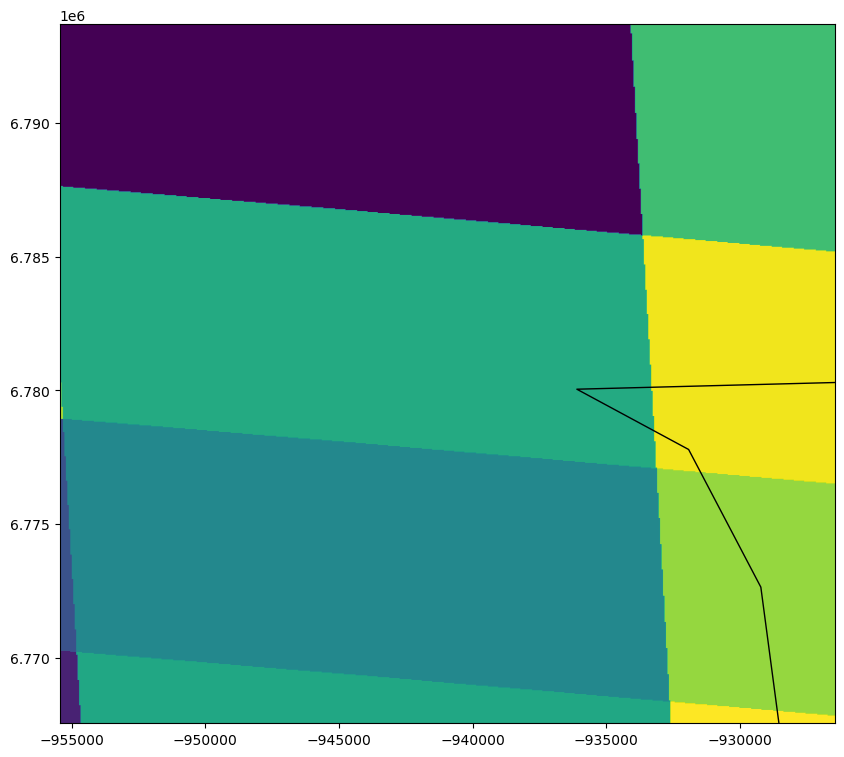

In [36]:
plot_request(request_raw, bbox_europe)

We can see here that even though the data is already mosaiced together, filling the entire bounding box, we do not have data everywhere since Tropomi does have a bunch of missing data per acquisition depending on atmospheric conditions. 

With this image we can already see some patterns but let's try to get a more representative image and take the mean of the NO2 values over an entire month to get a more complete picture.

To do this we do not have to download all of the data for an entire month, instead we can extend our evalscript so that the mean value for a month is calculated in the cloud for us. Doing it like this saves us a bunch of time downloading all images. So let's have a look at the updated evalscript:

The most important thing that changed is that we now changed the mosaicking input to ORBIT. This gives us all acquisitions for a time series to calculate values from. In the input we also have added `dataMask` as a band. This will tell us, if the NO2 band has data or not. We are using this to remove acquisitions without data from our calculation.

In our `evaluatePixel` function we have added two more steps. The first one is to filter out all acquisitions which do not have data with the `isClear()` function. After we have filtered the time series we can calculate the mean of all values using the `sum()` function and the length of the clear timeseries.

In the end we return the mean value we have calculated.

```js
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].NO2;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
```

In [37]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["O3", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].O3;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
"""

In [38]:
request_monthly = SentinelHubRequest(
    evalscript=evalscript_mean_mosaic,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2022-12-01", "2023-01-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox_europe,
    resolution=(500, 350),
    config=config,
    data_folder="./Data",
)

We now made a request for an entire month of data, for December of 2022. Other than that nothing much changed in the request.

In [39]:
mean_data = request_monthly.get_data(save_data=True)
# mean_data

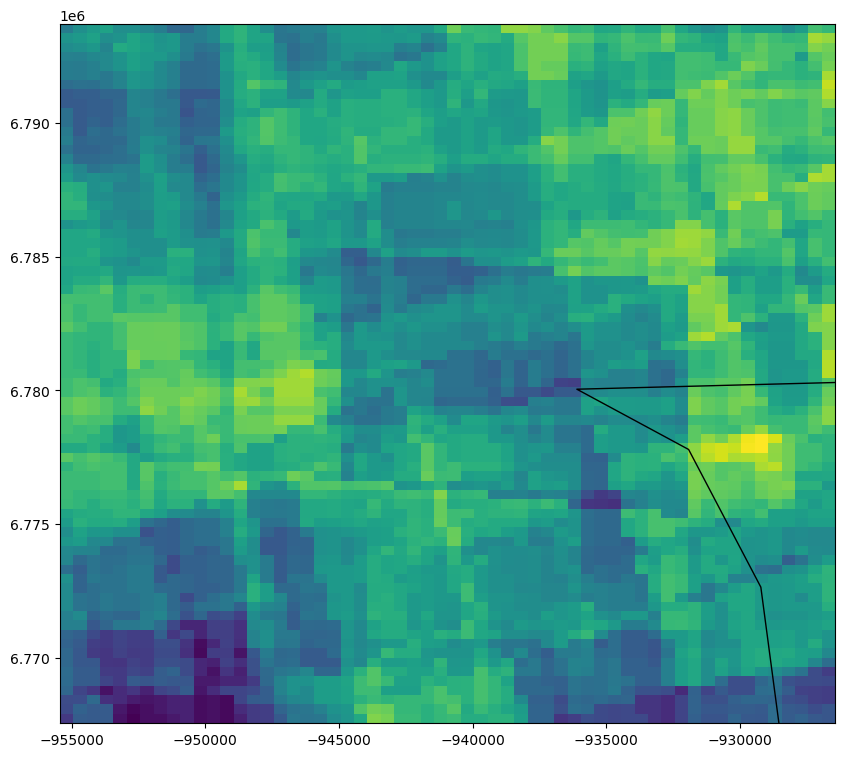

In [40]:
plot_request(request_monthly, bbox_europe)

In [47]:
evalscript_series = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "CLOUD_OPTICAL_THICKNESS",
          "dataMask"
        ]
      }
    ],
    output: [
      {
        id: "CLOUD_OPTICAL_THICKNESS",
        bands: ["CLOUD_OPTICAL_THICKNESS"]
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}

function evaluatePixel(samples) {
    return {
      CLOUD_OPTICAL_THICKNESS: [samples.CLOUD_OPTICAL_THICKNESS],
      dataMask: [samples.dataMask]
    };
}
"""

In [48]:
request_series = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript_series,
        time_interval=("2017-01-01", "2024-12-31"),
        aggregation_interval="P1D",
        size=(631, 1047),
    ),
    input_data=[SentinelHubStatistical.input_data(DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url),
                                                 other_args={"dataFilter": {"maxCloudCoverage": 10}}, 
                                                 )
                                                  ],
    bbox=bbox_europe,
    config=config,
    data_folder="./Data",
)

In [49]:
raw_data_series = request_series.get_data(save_data=True)
# raw_data_series

DownloadFailedException: Failed to download from:
https://sh.dataspace.copernicus.eu/api/v1/statistics
with HTTPError:
403 Client Error: Forbidden for url: https://sh.dataspace.copernicus.eu/api/v1/statistics
Server response: "{"status": 403, "reason": "Forbidden", "message": "Insufficient processing units or requests available in your account. Upgrade account or acquire additional credits.", "code": "ACCESS_INSUFFICIENT_PROCESSING_UNITS"}"

Change .json to pandas frame

In [44]:
# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data["outputs"].items():
        stats = value["bands"]["CLOUD_TOP_HEIGHT"]["stats"]
        if stats["sampleCount"] == stats["noDataCount"]:
            continue
        else:
            d["date"] = [date]
            for stat_name, stat_value in stats.items():
                if stat_name == "sampleCount" or stat_name == "noDataCount":
                    continue
                else:
                    d[f"{key}_{stat_name}"] = [stat_value]
    return pd.DataFrame(d)


def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq["interval"]["from"][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

In [45]:
result = read_acquisitions_stats(raw_data_series[0]["data"])
result

,date,CLOUD_TOP_HEIGHT_min,CLOUD_TOP_HEIGHT_max,CLOUD_TOP_HEIGHT_mean,CLOUD_TOP_HEIGHT_stDev
0,2018-04-30,626.192688,2875.697021,1557.332021,719.571501
0,2018-05-01,1498.558472,2846.917480,2352.820224,383.854759
0,2018-05-02,807.001709,1483.135742,1026.426460,200.861078
0,2018-05-03,1478.603394,2023.601807,1809.111249,129.454666
0,2018-05-06,2981.064209,4929.102051,3793.007461,796.232351
...,...,...,...,...,...
0,2024-03-03,698.730957,2851.510498,2119.262445,463.500449
0,2024-03-04,3888.562988,5469.611816,4856.367516,496.450545
0,2024-03-05,731.426697,1300.960205,1108.288123,169.141978
0,2024-03-06,553.927979,730.377808,658.789852,81.948845


Plot Data:

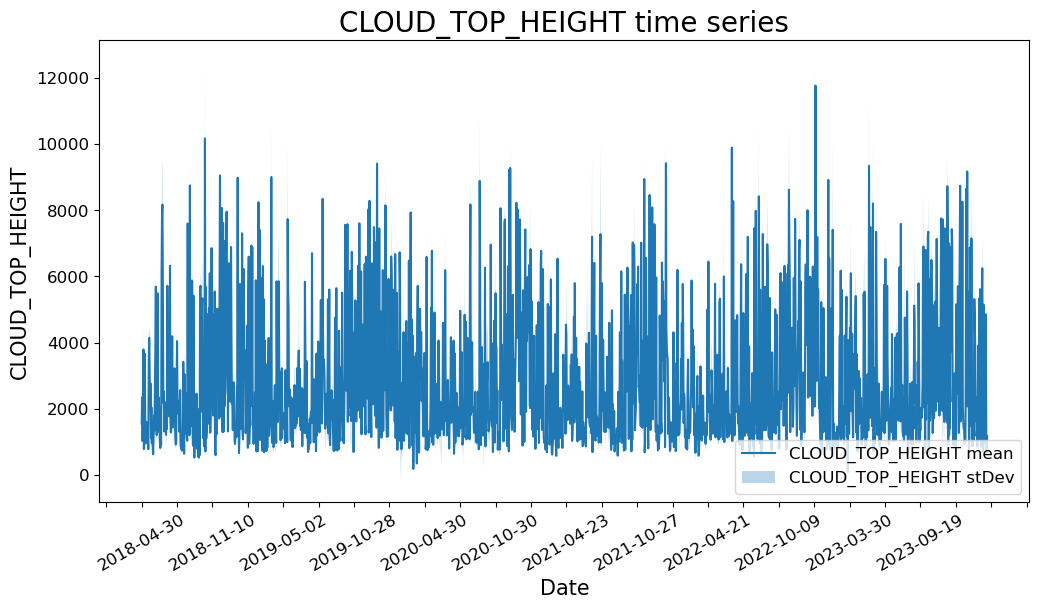

In [46]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))
t1 = result["date"]
NO2_mean = result["CLOUD_TOP_HEIGHT_mean"]
NO2_std = result["CLOUD_TOP_HEIGHT_stDev"]
ax_stat.plot(t1, NO2_mean, label="CLOUD_TOP_HEIGHT mean")
ax_stat.fill_between(
    t1,
    NO2_mean - NO2_std,
    NO2_mean + NO2_std,
    alpha=0.3,
    label="CLOUD_TOP_HEIGHT stDev",
)

ax_stat.xaxis.set_major_locator(MaxNLocator(nbins=30))
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)
ax_stat.set_xlabel("Date", size=15)
ax_stat.set_ylabel("CLOUD_TOP_HEIGHT", size=15)
ax_stat.legend(loc="lower right", prop={"size": 12})
ax_stat.set_title("CLOUD_TOP_HEIGHT time series", fontsize=20)
for label in ax_stat.get_xticklabels()[1::2]:
    label.set_visible(False)

In [21]:
result["date"] = pd.to_datetime(result['date'])
datadf = result[['date', 'CLOUD_TOP_HEIGHT_mean']].set_index('date')
datadf

,CLOUD_TOP_HEIGHT_mean
date,
2018-04-30,1557.332021
2018-05-01,2352.820224
2018-05-02,1026.426460
2018-05-03,1809.111249
2018-05-06,3793.007461
...,...
2024-03-03,2119.262445
2024-03-04,4856.367516
2024-03-05,1108.288123


In [22]:
X = (datadf.index.year + datadf.index.month/12.0 + datadf.index.day/365.0).to_numpy().reshape(-1, 1)
y = datadf["CLOUD_TOP_HEIGHT_mean"].to_numpy()
y = y*(1e-3)

# Split value
split_value = 2023

# Boolean indexing to split the array
X1 = X[X < split_value].reshape(-1,1)
X2 = X[X >= split_value].reshape(-1,1)

y1 = y[:len(X1)]
y2 = y[len(X1):]

X1


array([[2018.41552511],
       [2018.41940639],
       [2018.42214612],
       ...,
       [2022.993379  ],
       [2022.99611872],
       [2022.99885845]])

2.96**2 * RBF(length_scale=1.26e+12) * ExpSineSquared(length_scale=5.02, periodicity=0.914) + WhiteKernel(noise_level=3.42)


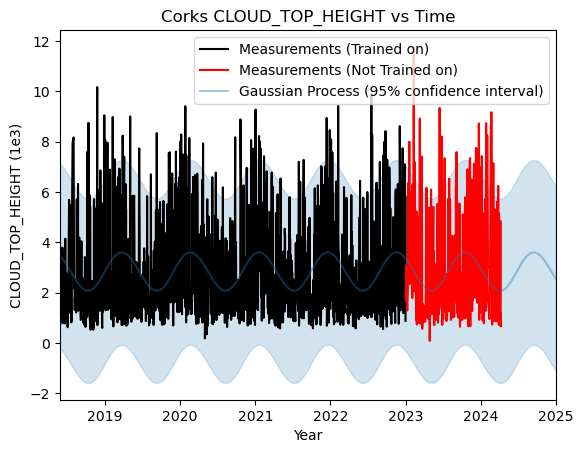

In [26]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y1.size), size=100, replace=False)
X_train, y_train = X1[training_indices], y1[training_indices]

from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import RBF
long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0, length_scale_bounds=(1e-10, 1e10))

from sklearn.gaussian_process.kernels import ExpSineSquared
seasonal_kernel = (2.0**2* RBF(length_scale=100.0, length_scale_bounds=(1e-10, 1e15))
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds=(0.75, 1.25)))

from sklearn.gaussian_process.kernels import RationalQuadratic
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

from sklearn.gaussian_process.kernels import WhiteKernel
noise_kernel = WhiteKernel(
   noise_level=0.1**2, noise_level_bounds=(1e-5,1e5))

# Thus, our final kernel is an addition of all previous kernel.
temp_kernel = (seasonal_kernel
                + noise_kernel)

gaussian_process = GaussianProcessRegressor(kernel=temp_kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
print(gaussian_process.kernel_)

import datetime
import numpy as np
today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=2018.4, stop=2025, num = 1_000).reshape(-1, 1)
mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

plt.plot(X1, y1, color="black", label="Measurements (Trained on)")
plt.plot(X2, y2, color="red", label="Measurements (Not Trained on)")
plt.plot(X_test, mean_prediction, color="tab:blue", alpha=0.4, label="Gaussian Process (95% confidence interval)")
plt.fill_between(
    X_test.ravel(),
    mean_prediction - 1.96*std_prediction,
    mean_prediction + 1.96*std_prediction,
    color="tab:blue",
    alpha=0.2,
)
plt.xlim(2018.4, 2025)
plt.legend()
plt.xlabel("Year")
plt.ylabel("CLOUD_TOP_HEIGHT (1e3)")
plt.title("Corks CLOUD_TOP_HEIGHT vs Time")
plt.savefig('sample_plot_high_res.png', dpi=1000)
plt.show()


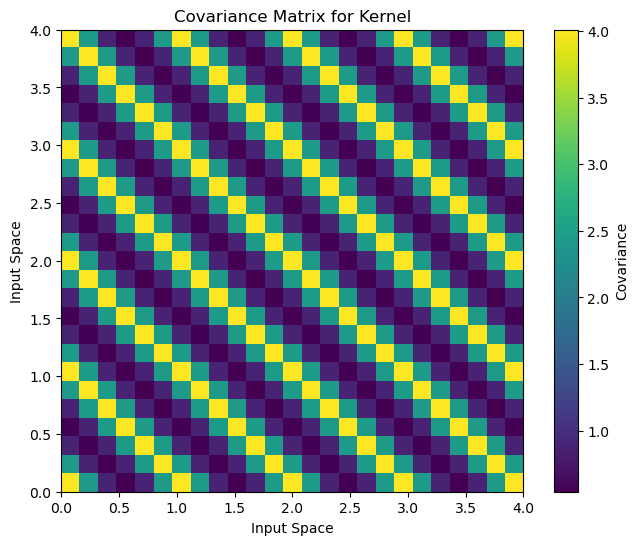

In [27]:
# Define input space
N = 25
Z = np.linspace(0, 4, N).reshape(-1, 1)  # Reshape for sklearn compatibility

# Compute covariance matrix
cov_matrix = temp_kernel(Z)

# Plot covariance matrix
plt.figure(figsize=(8, 6))
plt.imshow(cov_matrix, cmap='viridis', origin='upper', extent=[0, 4, 0, 4])
plt.colorbar(label='Covariance')
plt.title('Covariance Matrix for Kernel')
plt.xlabel('Input Space')
plt.ylabel('Input Space')
plt.show()